In [1]:
"""
Asymmetric Penalty Binary Cross-Entropy Loss

A novel loss function that combines label smoothing with asymmetric penalties:
- Minimum at smoothed label (not at hard labels)
- Steeper penalty toward opposing class
- Gentler penalty toward actual class

Mathematical Foundation:
1. Standard BCE: -[y*log(p) + (1-y)*log(1-p)]
2. Label Smoothing: Replace y with y_smooth = y*(1-ε) + (1-y)*ε
3. Asymmetric Penalty: Add directional penalties around the smoothed optimum
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryFocalCrossentropy

2025-09-25 01:32:35.775222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 01:32:35.807048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 01:32:36.464387: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:

def standard_binary_crossentropy(y_true, y_pred):
    """Standard Binary Cross-Entropy Loss"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def label_smoothing_binary_crossentropy(y_true, y_pred, label_smoothing=0.1):
    """Binary Cross-Entropy with Standard Label Smoothing"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Apply label smoothing: y=1 → 1-ε, y=0 → ε
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing

    return -tf.reduce_mean(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

def asymmetric_penalty_binary_crossentropy(y_true, y_pred, label_smoothing=0.1, asymmetry_strength=0.5):
    """
    Asymmetric Penalty Binary Cross-Entropy Loss

    Features:
    - Minimum at smoothed label: p = 1-ε (true=1), p = ε (true=0)
    - Steeper penalty toward opposing class
    - Gentler penalty toward actual class

    Args:
        y_true: Ground truth binary labels
        y_pred: Predicted probabilities
        label_smoothing: Smoothing parameter ε (0.05-0.15 recommended)
        asymmetry_strength: Controls penalty asymmetry (0.3-0.8 recommended)
    """
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Base with label smoothing
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss = -(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

    # Optimal prediction points
    optimal = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss_optimal = -(y_smooth * tf.math.log(optimal) + (1 - y_smooth) * tf.math.log(1 - optimal))

    # Normalize so min = 0
    base_loss = base_loss - base_loss_optimal

    # Distance from optimal points
    optimal_true1 = 1 - label_smoothing
    optimal_true0 = label_smoothing
    dist_from_optimal_true1 = tf.abs(y_pred - optimal_true1)
    dist_from_optimal_true0 = tf.abs(y_pred - optimal_true0)

    # Asymmetric penalties
    penalty_true1 = y_true * tf.where(
        y_pred < optimal_true1,
        asymmetry_strength * dist_from_optimal_true1**2,
        asymmetry_strength * 0.3 * dist_from_optimal_true1**2
    )

    penalty_true0 = (1 - y_true) * tf.where(
        y_pred > optimal_true0,
        asymmetry_strength * dist_from_optimal_true0**2,
        asymmetry_strength * 0.3 * dist_from_optimal_true0**2
    )

    total_loss = tf.reduce_mean(base_loss + penalty_true1 + penalty_true0)
    return tf.maximum(0.0, total_loss)


# Numpy implementations
def np_standard_bce(y_true, p_values):
    """NumPy implementation for plotting"""
    return -(y_true * np.log(p_values) + (1 - y_true) * np.log(1 - p_values))

def np_label_smoothing_bce(y_true, p_values, label_smoothing=0.1):
    """NumPy implementation for plotting"""
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    return -(y_smooth * np.log(p_values) + (1 - y_smooth) * np.log(1 - p_values))

def np_asymmetric_penalty_bce(y_true, p_values, label_smoothing=0.1, asymmetry_strength=0.5):
    """NumPy implementation for plotting"""
    # Base loss
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_loss = -(y_smooth * np.log(p_values) + (1 - y_smooth) * np.log(1 - p_values))

    # Optimal point
    optimal = (1 - label_smoothing) if y_true == 1 else label_smoothing
    base_loss_optimal = -(y_smooth * np.log(optimal) + (1 - y_smooth) * np.log(1 - optimal))

    # Normalize so minimum = 0
    base_loss = base_loss - base_loss_optimal

    # Asymmetric penalty
    dist = np.abs(p_values - optimal)
    if y_true == 1:
        penalty = np.where(
            p_values < optimal,  # Toward opposing class (0)
            asymmetry_strength * dist**2,
            asymmetry_strength * 0.3 * dist**2
        )
    else:
        penalty = np.where(
            p_values > optimal,  # Toward opposing class (1)
            asymmetry_strength * dist**2,
            asymmetry_strength * 0.3 * dist**2
        )

    return np.maximum(0.0, base_loss + penalty)


def np_focal_loss(y_true, p_values, gamma=2.0, alpha=0.25, label_smoothing=0.0, apply_class_balancing=False):
    """Binary Focal Loss using tf.keras.losses.BinaryFocalCrossentropy (NumPy-friendly)."""
    p = np.clip(np.asarray(p_values, dtype=np.float32), 1e-7, 1 - 1e-7)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
    p_tf = tf.reshape(p_tf, (-1, 1))
    y_tf = tf.fill(tf.shape(p_tf), float(y_true))
    loss_fn = BinaryFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=False,
        label_smoothing=label_smoothing,
        reduction=tf.keras.losses.Reduction.NONE,
        apply_class_balancing=apply_class_balancing
    )
    losses = loss_fn(y_tf, p_tf)  # shape: (N,)
    return tf.reshape(losses, (-1,)).numpy()

def np_gradient_focal_loss(y_true, p_values, gamma=2.0, alpha=0.25, label_smoothing=0.0, apply_class_balancing=False):
    """Gradient of Binary Focal Loss w.r.t. predicted probability p using autodiff."""
    p = np.clip(np.asarray(p_values, dtype=np.float32), 1e-7, 1 - 1e-7)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
    p_tf = tf.reshape(p_tf, (-1, 1))
    p_var = tf.Variable(p_tf)
    y_tf = tf.fill(tf.shape(p_var), float(y_true))
    loss_fn = BinaryFocalCrossentropy(
        gamma=gamma,
        alpha=alpha,
        from_logits=False,
        label_smoothing=label_smoothing,
        reduction=tf.keras.losses.Reduction.NONE,
        apply_class_balancing=apply_class_balancing
    )
    with tf.GradientTape() as tape:
        tape.watch(p_var)
        losses = loss_fn(y_tf, p_var)  # per-sample loss (N,)
        loss_sum = tf.reduce_sum(losses)
    grad = tape.gradient(loss_sum, p_var)
    return tf.reshape(grad, (-1,)).numpy()



# Gradient calculation
def np_gradient_standard_bce(y_true, p_values):
    """Gradient of standard BCE w.r.t. predicted probability"""
    return -(y_true / p_values) + (1 - y_true) / (1 - p_values)

def np_gradient_label_smoothing_bce(y_true, p_values, label_smoothing=0.1):
    """Gradient of label smoothing BCE w.r.t. predicted probability"""
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    return -(y_smooth / p_values) + (1 - y_smooth) / (1 - p_values)

def np_gradient_asymmetric_penalty_bce(y_true, p_values, label_smoothing=0.1, asymmetry_strength=0.5):
    """Gradient of asymmetric penalty BCE w.r.t. predicted probability"""
    # Base gradient
    y_smooth = y_true * (1 - label_smoothing) + (1 - y_true) * label_smoothing
    base_grad = -(y_smooth / p_values) + (1 - y_smooth) / (1 - p_values)

    # Optimal point
    optimal = (1 - label_smoothing) if y_true == 1 else label_smoothing
    base_grad_optimal = -(y_smooth / optimal) + (1 - y_smooth) / (1 - optimal)
    base_grad = base_grad - base_grad_optimal  # normalize

    # Penalty gradient
    if y_true == 1:
        penalty_grad = np.where(
            p_values < optimal,
            2 * asymmetry_strength * (p_values - optimal),      # Strong gradient toward opposing
            2 * asymmetry_strength * 0.3 * (p_values - optimal) # Weak gradient toward actual
        )
    else:
        penalty_grad = np.where(
            p_values > optimal,
            2 * asymmetry_strength * (p_values - optimal),
            2 * asymmetry_strength * 0.3 * (p_values - optimal)
        )

    return base_grad + penalty_grad


In [3]:

# Visualizations
def plot_loss_comparison(label_smoothing=0.1, asymmetry_strength=0.5, focal_gamma=2.0, focal_alpha=0.25):
    """Create comprehensive comparison plots"""

    # Prediction probability range
    p_values = np.linspace(0.001, 0.999, 1000)

    # Calculate losses for both true classes
    losses = {}
    gradients = {}

    for y_true in [0, 1]:
        class_name = f"True={y_true}"

        # Calculate all loss types
        losses[class_name] = {
            'Standard BCE': np_standard_bce(y_true, p_values),
            'Label Smoothing': np_label_smoothing_bce(y_true, p_values, label_smoothing),
            'Asymmetric Penalty': np_asymmetric_penalty_bce(y_true, p_values, label_smoothing, asymmetry_strength),
            'Focal Loss': np_focal_loss(y_true, p_values, gamma=focal_gamma, alpha=focal_alpha, label_smoothing=label_smoothing, apply_class_balancing = True if label_smoothing > 0 else False)
        }

        # Calculate gradients
        gradients[class_name] = {
            'Standard BCE': np_gradient_standard_bce(y_true, p_values),
            'Label Smoothing': np_gradient_label_smoothing_bce(y_true, p_values, label_smoothing),
            'Asymmetric Penalty': np_gradient_asymmetric_penalty_bce(y_true, p_values, label_smoothing, asymmetry_strength),
            'Focal Loss': np_gradient_focal_loss(y_true, p_values, gamma=focal_gamma, alpha=focal_alpha, label_smoothing=label_smoothing, apply_class_balancing = True if label_smoothing > 0 else False)
        }

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    colors = {'Standard BCE': 'black', 'Label Smoothing': 'blue', 'Asymmetric Penalty': 'red', 'Focal Loss': 'green'}
    styles = {'Standard BCE': '-', 'Label Smoothing': '--', 'Asymmetric Penalty': '-', 'Focal Loss': '-.'}

    #--------------------------------------------------------------------------
    # Plot 1: Loss curves for True=1
    #--------------------------------------------------------------------------
    ax = axes[0, 0]

    for method_name, loss_values in losses['True=1'].items():
        ax.plot(p_values, loss_values, color=colors[method_name],
               linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

        # Find and mark minimum
        min_idx = np.argmin(loss_values)
        min_p = p_values[min_idx]
        min_loss = loss_values[min_idx]

        marker = 'o' if method_name == 'Standard BCE' else ('s' if 'Label' in method_name else '*')
        ax.scatter(min_p, min_loss, color=colors[method_name], s=120, marker=marker,
                  edgecolor='white', linewidth=2, zorder=10)

        # Annotate minimum
        if method_name == 'Standard BCE':
            ax.annotate(f'Min: p=1.0', xy=(min_p, min_loss), xytext=(0.85, min_loss+0.5),
                       arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                       fontsize=10, ha='center')
        else:
            ax.annotate(f'Min: p={min_p:.2f}', xy=(min_p, min_loss), xytext=(min_p-0.1, min_loss+0.3),
                       arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                       fontsize=10, ha='center')

    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves: True Label = 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 4)

    #--------------------------------------------------------------------------
    # Plot 2: Loss curves for True=0
    #--------------------------------------------------------------------------
    ax = axes[0, 1]

    for method_name, loss_values in losses['True=0'].items():
        ax.plot(p_values, loss_values, color=colors[method_name],
               linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

        # Find and mark minimum
        min_idx = np.argmin(loss_values)
        min_p = p_values[min_idx]
        min_loss = loss_values[min_idx]

        marker = 'o' if method_name == 'Standard BCE' else ('s' if 'Label' in method_name else '*')
        ax.scatter(min_p, min_loss, color=colors[method_name], s=120, marker=marker,
                  edgecolor='white', linewidth=2, zorder=10)

        # Annotate minimum
        if method_name == 'Standard BCE':
            ax.annotate(f'Min: p=0.0', xy=(min_p, min_loss), xytext=(0.15, min_loss+0.5),
                       arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                       fontsize=10, ha='center')
        else:
            ax.annotate(f'Min: p={min_p:.2f}', xy=(min_p, min_loss), xytext=(min_p+0.1, min_loss+0.3),
                       arrowprops=dict(arrowstyle='->', color=colors[method_name]),
                       fontsize=10, ha='center')

    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves: True Label = 0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 4)

    #--------------------------------------------------------------------------
    # Plot 3: Gradients for True=1
    #--------------------------------------------------------------------------
    ax = axes[1, 0]

    # Clip gradients for better visualization
    p_clip = p_values[(p_values > 0.05) & (p_values < 0.95)]

    for method_name, grad_values in gradients['True=1'].items():
        grad_clip = grad_values[(p_values > 0.05) & (p_values < 0.95)]

        ax.plot(p_clip, grad_clip, color=colors[method_name],
               linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Gradient')
    ax.set_title('Gradients: True Label = 1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)

    # Add annotations for gradient interpretation
    ax.annotate('Steep negative:\nStrong pull toward 1',
               xy=(0.1, -15), xytext=(0.2, -18),
               arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
               fontsize=9, ha='center', color='red')

    ax.annotate('Steep positive:\nStrong pull from 0',
               xy=(0.1, 15), xytext=(0.2, 18),
               arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
               fontsize=9, ha='center', color='red')

    #--------------------------------------------------------------------------
    # Plot 4: Gradients for True=0
    #--------------------------------------------------------------------------
    ax = axes[1, 1]

    for method_name, grad_values in gradients['True=0'].items():
        grad_clip = grad_values[(p_values > 0.05) & (p_values < 0.95)]

        ax.plot(p_clip, grad_clip, color=colors[method_name],
               linestyle=styles[method_name], linewidth=2.5, label=method_name, alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Gradient')
    ax.set_title('Gradients: True Label = 0')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)

    plt.tight_layout()
    plt.show()

    # Print summary of key characteristics
    print("="*80)
    print("ASYMMETRIC PENALTY BINARY CROSS-ENTROPY ANALYSIS")
    print("="*80)

    print(f"\nPARAMETERS:")
    print(f"  Label smoothing (ε): {label_smoothing}")
    print(f"  Asymmetry strength: {asymmetry_strength}")
    print(f"  Focal gamma: {focal_gamma}")
    print(f"  Focal alpha: {focal_alpha}")

    print(f"\nMINIMA LOCATIONS:")
    for y_true in [0, 1]:
        class_name = f"True={y_true}"
        print(f"  {class_name}:")
        for method_name, loss_values in losses[class_name].items():
            min_idx = np.argmin(loss_values)
            min_p = p_values[min_idx]
            print(f"    {method_name}: p = {min_p:.3f}")

    print(f"\nKEY CHARACTERISTICS:")
    print(f"✅ Standard BCE: Minima at hard labels (0, 1)")
    print(f"✅ Label Smoothing: Minima at smoothed labels ({label_smoothing:.1f}, {1-label_smoothing:.1f})")
    print(f"✅ Asymmetric Penalty: Minima at smoothed labels + asymmetric penalties")
    print(f"   • Steeper penalty toward opposing class")
    print(f"   • Gentler penalty toward actual class")
    print(f"   • Better regularization properties")
    print(f"✅ Focal Loss: Focuses learning on hard examples via (1-p_t)^γ weighting")

    print("="*80)


Asymmetric Penalty Binary Cross-Entropy Loss

Sample Loss Calculations:
Standard BCE: 0.2310
Label Smoothing BCE: 0.3832
Asymmetric Penalty BCE: 0.1582
Focal Loss (TF/Keras): 0.0113

Generating comprehensive visualization...


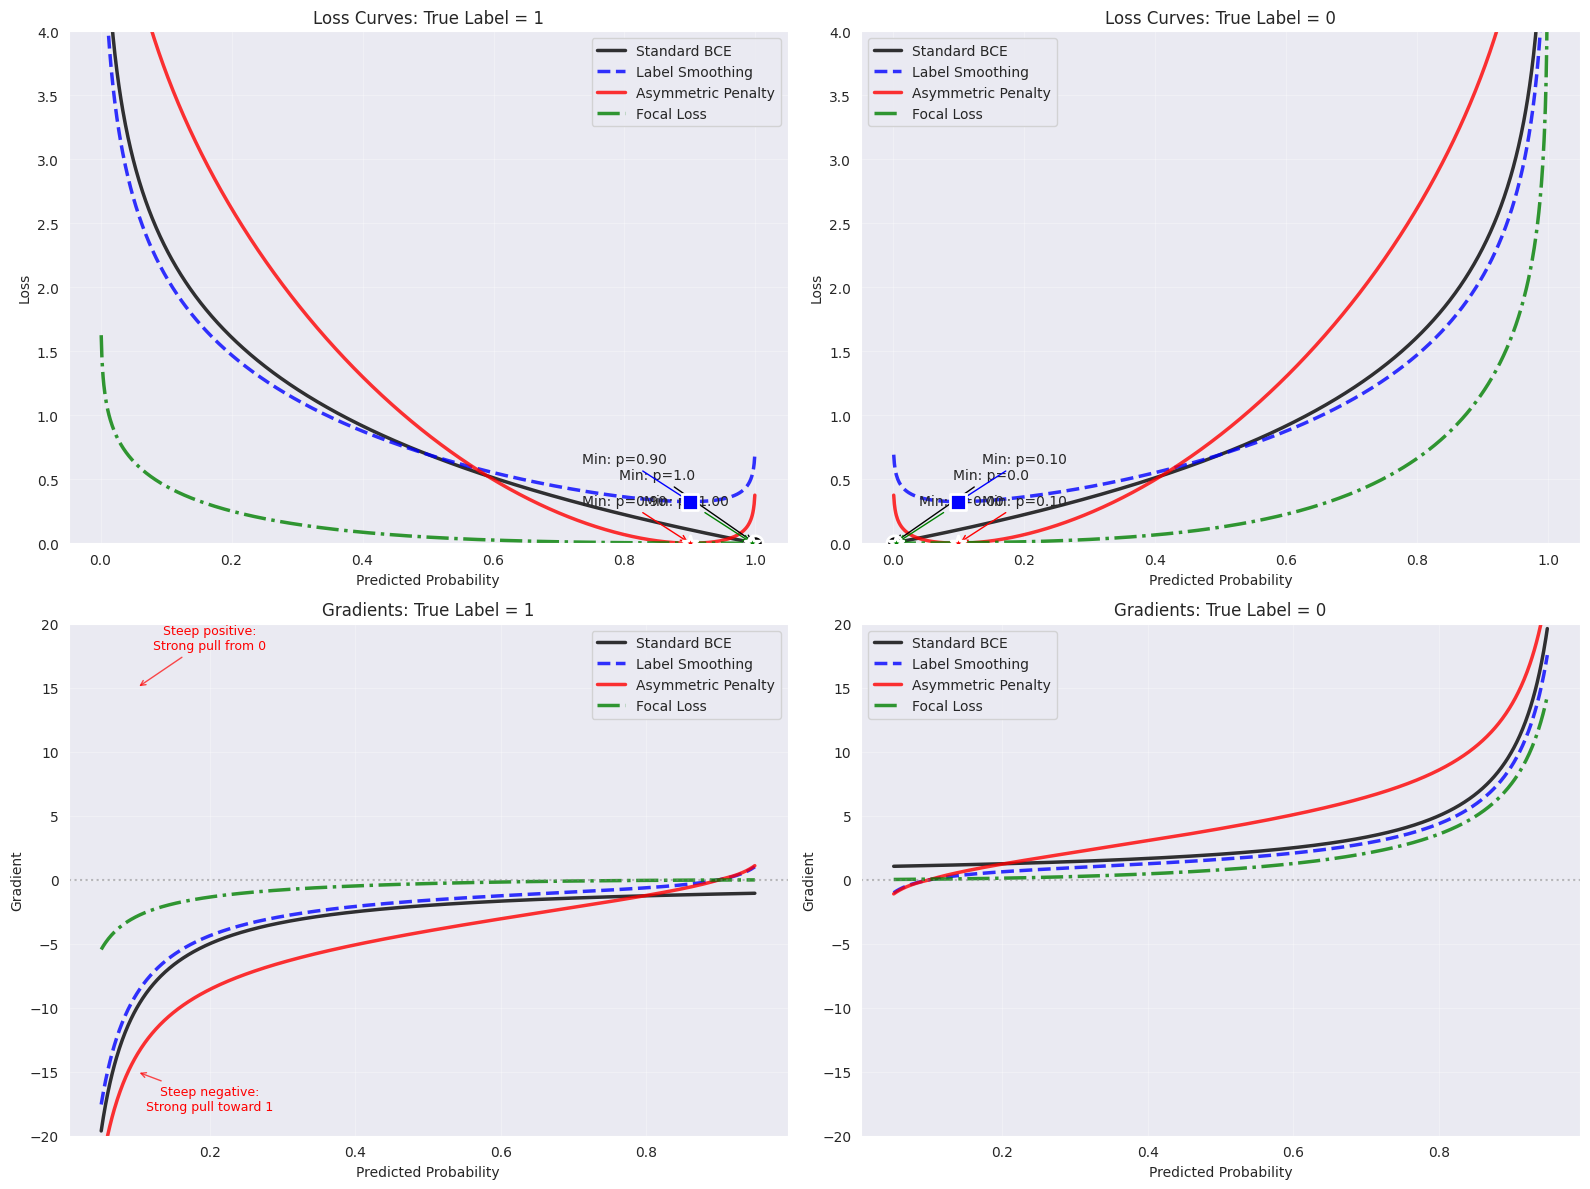

ASYMMETRIC PENALTY BINARY CROSS-ENTROPY ANALYSIS

PARAMETERS:
  Label smoothing (ε): 0.1
  Asymmetry strength: 3.0
  Focal gamma: 2.0
  Focal alpha: 0.25

MINIMA LOCATIONS:
  True=0:
    Standard BCE: p = 0.001
    Label Smoothing: p = 0.100
    Asymmetric Penalty: p = 0.100
    Focal Loss: p = 0.005
  True=1:
    Standard BCE: p = 0.999
    Label Smoothing: p = 0.900
    Asymmetric Penalty: p = 0.900
    Focal Loss: p = 0.995

KEY CHARACTERISTICS:
✅ Standard BCE: Minima at hard labels (0, 1)
✅ Label Smoothing: Minima at smoothed labels (0.1, 0.9)
✅ Asymmetric Penalty: Minima at smoothed labels + asymmetric penalties
   • Steeper penalty toward opposing class
   • Gentler penalty toward actual class
   • Better regularization properties
✅ Focal Loss: Focuses learning on hard examples via (1-p_t)^γ weighting


In [7]:
#==============================================================================
# DEMONSTRATION
#==============================================================================

if __name__ == "__main__":
    # Example usage
    print("Asymmetric Penalty Binary Cross-Entropy Loss")
    print("=" * 50)

    # Test with sample data
    y_true = tf.constant([1.0, 0.0, 1.0, 0.0])
    y_pred = tf.constant([0.9, 0.1, 0.7, 0.3])

    print("\nSample Loss Calculations:")
    print(f"Standard BCE: {standard_binary_crossentropy(y_true, y_pred).numpy():.4f}")
    print(f"Label Smoothing BCE: {label_smoothing_binary_crossentropy(y_true, y_pred, 0.10).numpy():.4f}")
    print(f"Asymmetric Penalty BCE: {asymmetric_penalty_binary_crossentropy(y_true, y_pred, 0.10, 5.).numpy():.4f}")
    fl = BinaryFocalCrossentropy(gamma=2.0, alpha=0.25, from_logits=False, label_smoothing=0.10, apply_class_balancing=True)
    print(f"Focal Loss (TF/Keras): {fl(y_true, y_pred).numpy():.4f}")

    print("\nGenerating comprehensive visualization...")
    plot_loss_comparison(label_smoothing=0.1, asymmetry_strength=3.0, focal_gamma=2.0, focal_alpha=0.25)